# MSA 2025 Phase 2 - Part 2: Minimum Temperature Prediction from Weather Data


In [22]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load and check the dataset


In [23]:
# Load the dataset
df = pd.read_csv("Summary of Weather.csv")
df.head(5)

/var/folders/8x/2pmf15g968sb9j42v5_888x00000gn/T/ipykernel_28263/2308459572.py:2: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Summary of Weather.csv")


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  object 
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-

The dataset contains **119040 rows** and **31 columns**.


### Check for missing values


<Figure size 1200x1000 with 0 Axes>

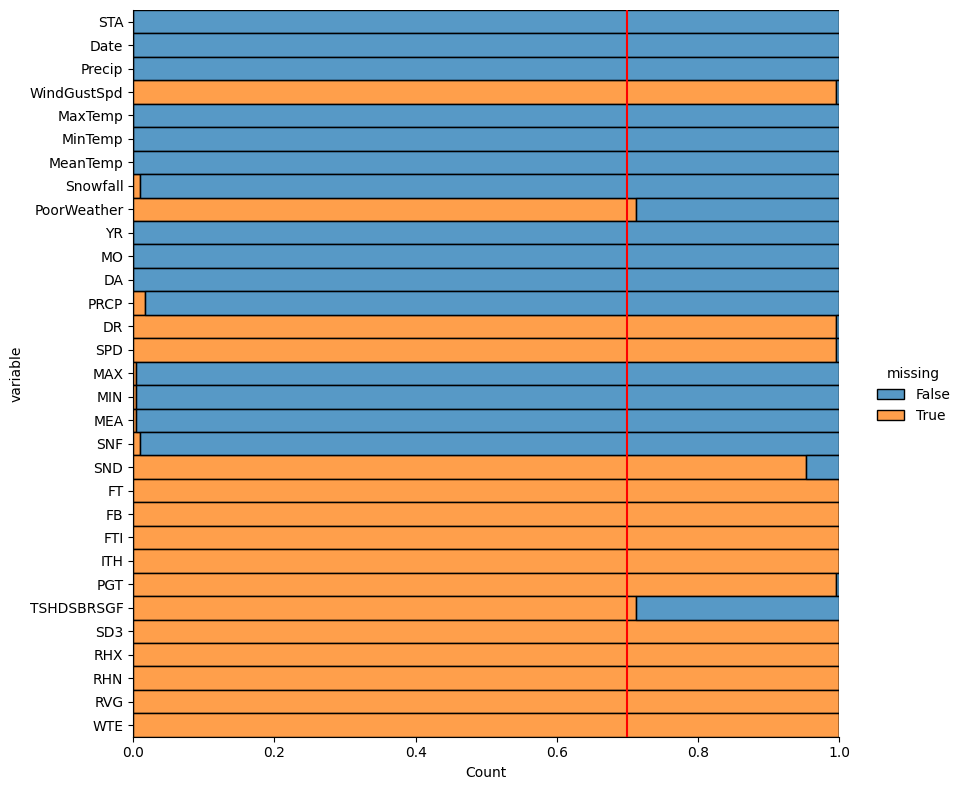

In [25]:
# Check for missing values
plt.figure(figsize=(12, 10))

sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=8,
    aspect=1.1,
)

# Specify a threshold value
plt.axvline(0.7, color="r")

I will drop variables that have more than 70% missing data.


In [26]:
df = df.drop(
    columns=[
        "WindGustSpd",
        "PoorWeather",
        "DR",
        "SPD",
        "SND",
        "FT",
        "FB",
        "FTI",
        "ITH",
        "PGT",
        "TSHDSBRSGF",
        "SD3",
        "RHX",
        "RHN",
        "RVG",
        "WTE",
    ]
)

### Drop unnecessary variables


In [27]:
df[["Date", "YR", "MO", "DA"]]

,Date,YR,MO,DA
0,1942-7-1,42,7,1
1,1942-7-2,42,7,2
2,1942-7-3,42,7,3
3,1942-7-4,42,7,4
4,1942-7-5,42,7,5
...,...,...,...,...
119035,1945-12-27,45,12,27
119036,1945-12-28,45,12,28
119037,1945-12-29,45,12,29
119038,1945-12-30,45,12,30


Since these four variables contain the same information, I will drop the Date variable.


In [28]:
df = df.drop(columns=["Date"])

I will drop the STA variable because it is a unique station identifier that does not contribute meaningful information for prediction.


In [29]:
df = df.drop(columns=["STA"])

In [30]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print(f"\nNumerical columns:", numerical_cols)
print(f"Categorical columns:", categorical_cols)


Numerical columns: ['MaxTemp', 'MinTemp', 'MeanTemp', 'YR', 'MO', 'DA', 'MAX', 'MIN', 'MEA']
Categorical columns: ['Precip', 'Snowfall', 'PRCP', 'SNF']


In [31]:
# Key statistical measures for numerical columns
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
             MaxTemp        MinTemp       MeanTemp             YR  \
count  119040.000000  119040.000000  119040.000000  119040.000000   
mean       27.045111      17.789511      22.411631      43.805284   
std         8.717817       8.334572       8.297982       1.136718   
min       -33.333333     -38.333333     -35.555556      40.000000   
25%        25.555556      15.000000      20.555556      43.000000   
50%        29.444444      21.111111      25.555556      44.000000   
75%        31.666667      23.333333      27.222222      45.000000   
max        50.000000      34.444444      40.000000      45.000000   

                  MO             DA            MAX            MIN  \
count  119040.000000  119040.000000  118566.000000  118572.000000   
mean        6.726016      15.797530      81.003745      64.273808   
std         3.425561       8.794541      14.869361      14.481498   
min         1.000000       1.000000     -28.000000     -37.000000   
25%     

### Visualization


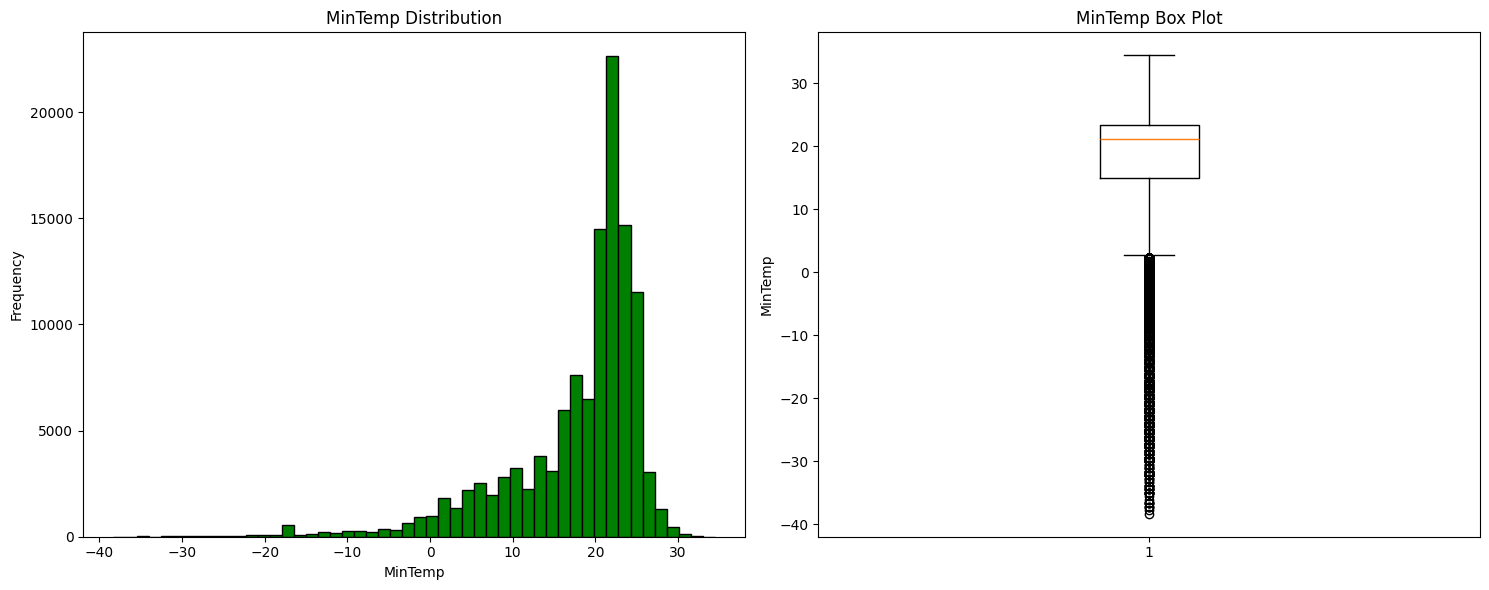

In [32]:
# Visualization of MinTemp Variable (Target Variable)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
ax1.hist(df["MinTemp"], bins=50, color="green", edgecolor="black")
ax1.set_title("MinTemp Distribution")
ax1.set_xlabel("MinTemp")
ax1.set_ylabel("Frequency")

# Box plot
ax2.boxplot(df["MinTemp"])
ax2.set_title("MinTemp Box Plot")
ax2.set_ylabel("MinTemp")

plt.tight_layout()
plt.show()

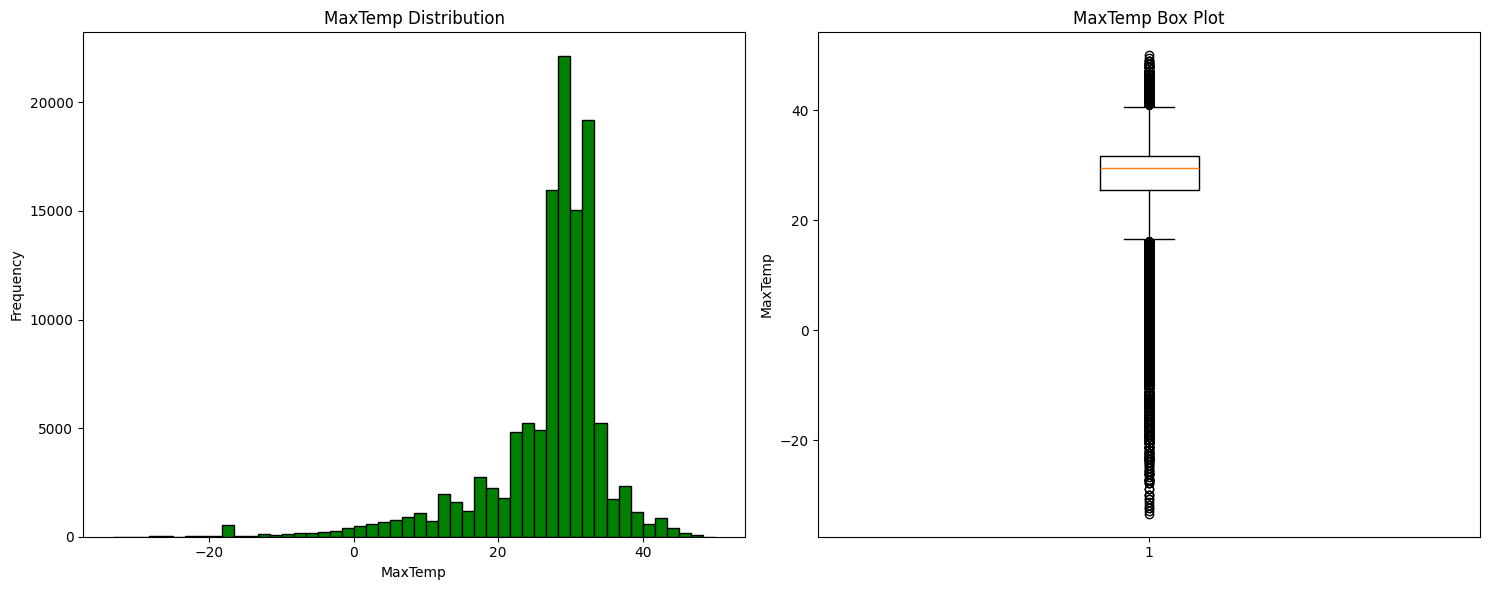

In [33]:
# Visualization of MaxTemp Variable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
ax1.hist(df["MaxTemp"], bins=50, color="green", edgecolor="black")
ax1.set_title("MaxTemp Distribution")
ax1.set_xlabel("MaxTemp")
ax1.set_ylabel("Frequency")

# Box plot
ax2.boxplot(df["MaxTemp"])
ax2.set_title("MaxTemp Box Plot")
ax2.set_ylabel("MaxTemp")

plt.tight_layout()
plt.show()

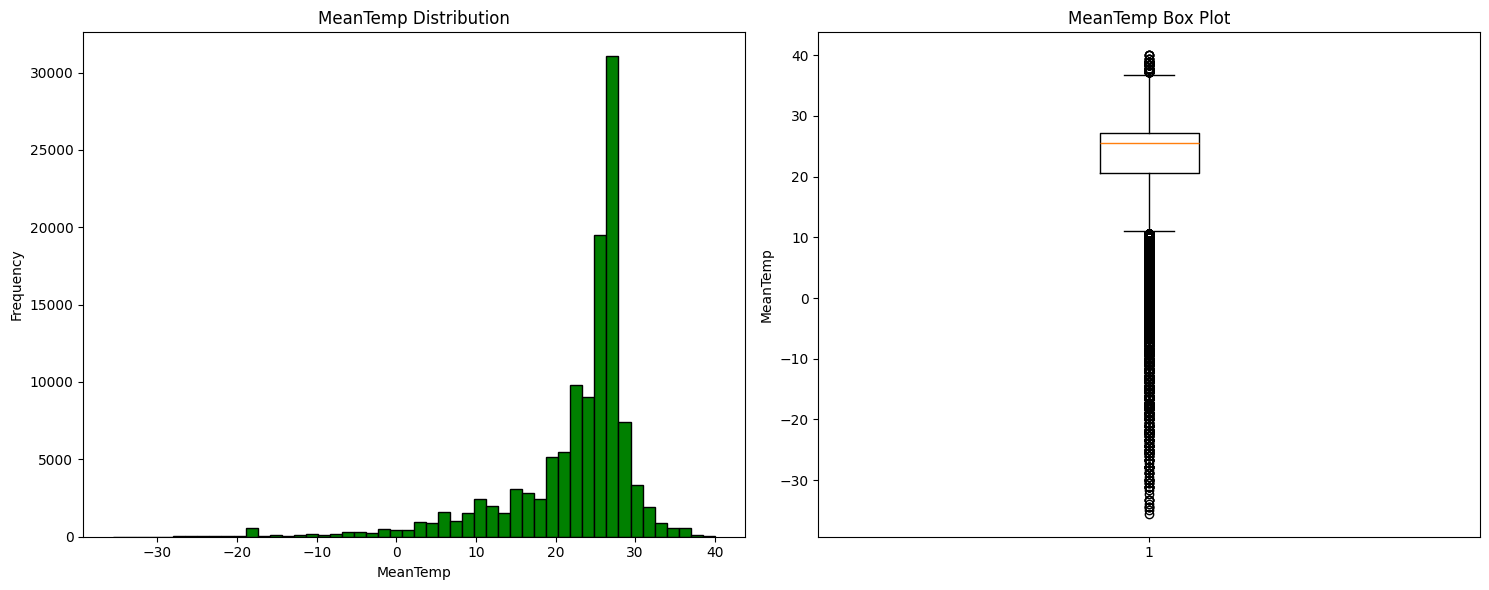

In [34]:
# Visualization of MeanTemp Variable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
ax1.hist(df["MeanTemp"], bins=50, color="green", edgecolor="black")
ax1.set_title("MeanTemp Distribution")
ax1.set_xlabel("MeanTemp")
ax1.set_ylabel("Frequency")

# Box plot
ax2.boxplot(df["MeanTemp"])
ax2.set_title("MeanTemp Box Plot")
ax2.set_ylabel("MeanTemp")

plt.tight_layout()
plt.show()

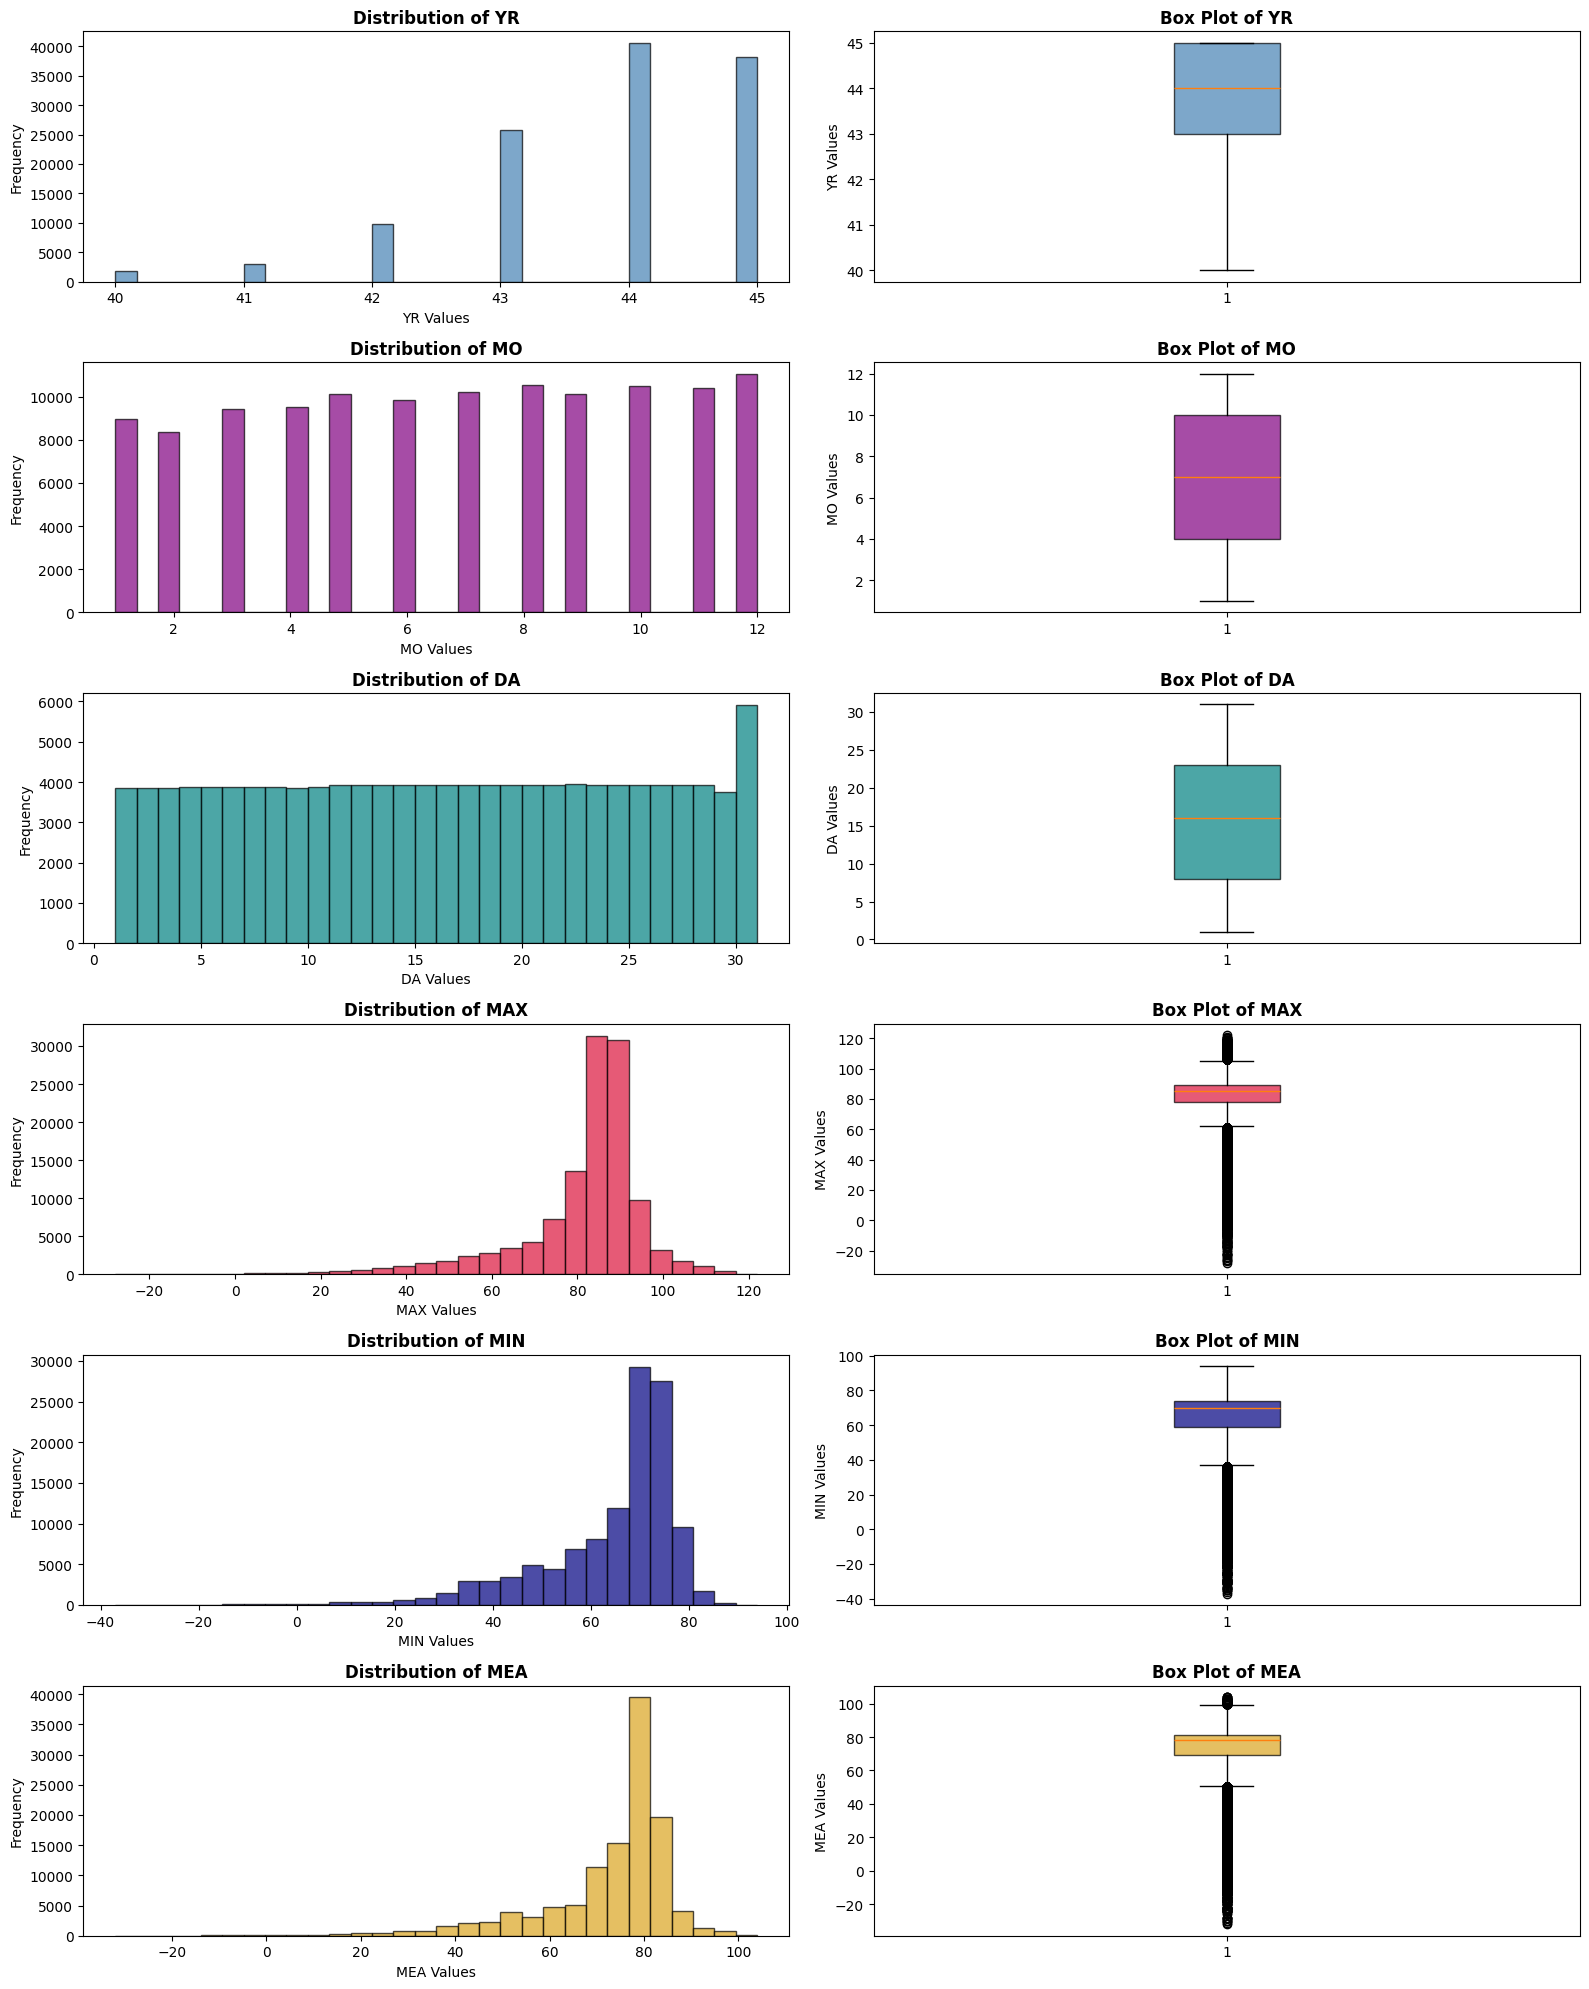

In [35]:
# Comprehensive Visualization: YR, MO, DA, MAX, MIN, MEA Variables
# Each variable shown with histogram and boxplot

fig, axes = plt.subplots(6, 2, figsize=(16, 20))
variables = ["YR", "MO", "DA", "MAX", "MIN", "MEA"]
colors = ["steelblue", "purple", "teal", "crimson", "navy", "goldenrod"]

for i, (var, color) in enumerate(zip(variables, colors)):
    if var in df.columns:
        # Remove missing values for cleaner visualization
        data = df[var]

        # Histogram (left column)
        axes[i, 0].hist(data, bins=30, alpha=0.7, color=color, edgecolor="black")
        axes[i, 0].set_title(f"Distribution of {var}", fontsize=12, fontweight="bold")
        axes[i, 0].set_xlabel(f"{var} Values")
        axes[i, 0].set_ylabel("Frequency")

        # Boxplot (right column)
        box_plot = axes[i, 1].boxplot(data.dropna(), patch_artist=True)
        box_plot["boxes"][0].set_facecolor(color)
        box_plot["boxes"][0].set_alpha(0.7)
        axes[i, 1].set_title(f"Box Plot of {var}", fontsize=12, fontweight="bold")
        axes[i, 1].set_ylabel(f"{var} Values")

plt.tight_layout()
plt.show()

### Clean categorical variables


In [36]:
for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(df[col].unique())


Unique values in Precip:
['1.016' '0' '2.54' 'T' '3.556' '0.508' '0.254' '1.778' '3.302' '0.762'
 '5.588' '5.08' '2.032' '25.654' '40.132' '19.05' '23.876' '4.064'
 '12.192' '2.794' '33.274' '19.304' '47.752' '6.35' '3.048' '8.382'
 '10.16' '27.178' '30.48' '45.212' '10.668' '15.494' '57.658' '58.166'
 '11.43' '31.242' '17.78' '26.924' '26.67' '6.604' '5.334' '4.826' '7.62'
 '8.636' '7.874' '12.446' '90.932' '13.462' '11.938' '5.842' '4.318'
 '6.096' '9.144' '4.572' '9.906' '9.652' '1.524' '13.97' '17.272' '33.528'
 '1.27' '13.716' '8.128' '22.352' '39.116' '36.068' '98.044' '3.81'
 '14.986' '78.232' '146.304' '14.732' '21.844' '120.904' '42.164' '23.368'
 '21.082' '44.958' '2.286' '50.038' '17.526' '51.054' '7.112' '25.4'
 '7.366' '16.256' '46.736' '8.89' '24.638' '11.684' '17.018' '144.78'
 '18.034' '50.8' '106.426' '36.576' '53.34' '34.798' '12.954' '26.416'
 '85.598' '47.498' '12.7' '11.176' '59.182' '33.782' '40.894' '28.194'
 '24.892' '14.478' '71.628' '102.108' '31.496' '36.322

All variables should be numeric; therefore, I will convert them from string to float, with invalid values being converted to NaN.


In [37]:
df["Precip"] = pd.to_numeric(df["Precip"], downcast="float", errors="coerce")
df["Snowfall"] = pd.to_numeric(df["Snowfall"], downcast="float", errors="coerce")
df["PRCP"] = pd.to_numeric(df["PRCP"], downcast="float", errors="coerce")
df["SNF"] = pd.to_numeric(df["SNF"], downcast="float", errors="coerce")

In [38]:
# Since some values cannot be converted to float, they will be set to NaN. We need to check for NaN values.
df.isnull().sum()

Precip      16753
MaxTemp         0
MinTemp         0
MeanTemp        0
Snowfall     1207
YR              0
MO              0
DA              0
PRCP        18685
MAX           474
MIN           468
MEA           498
SNF          1207
dtype: int64

In [39]:
# Drop the rows with NaN values
df = df.dropna()

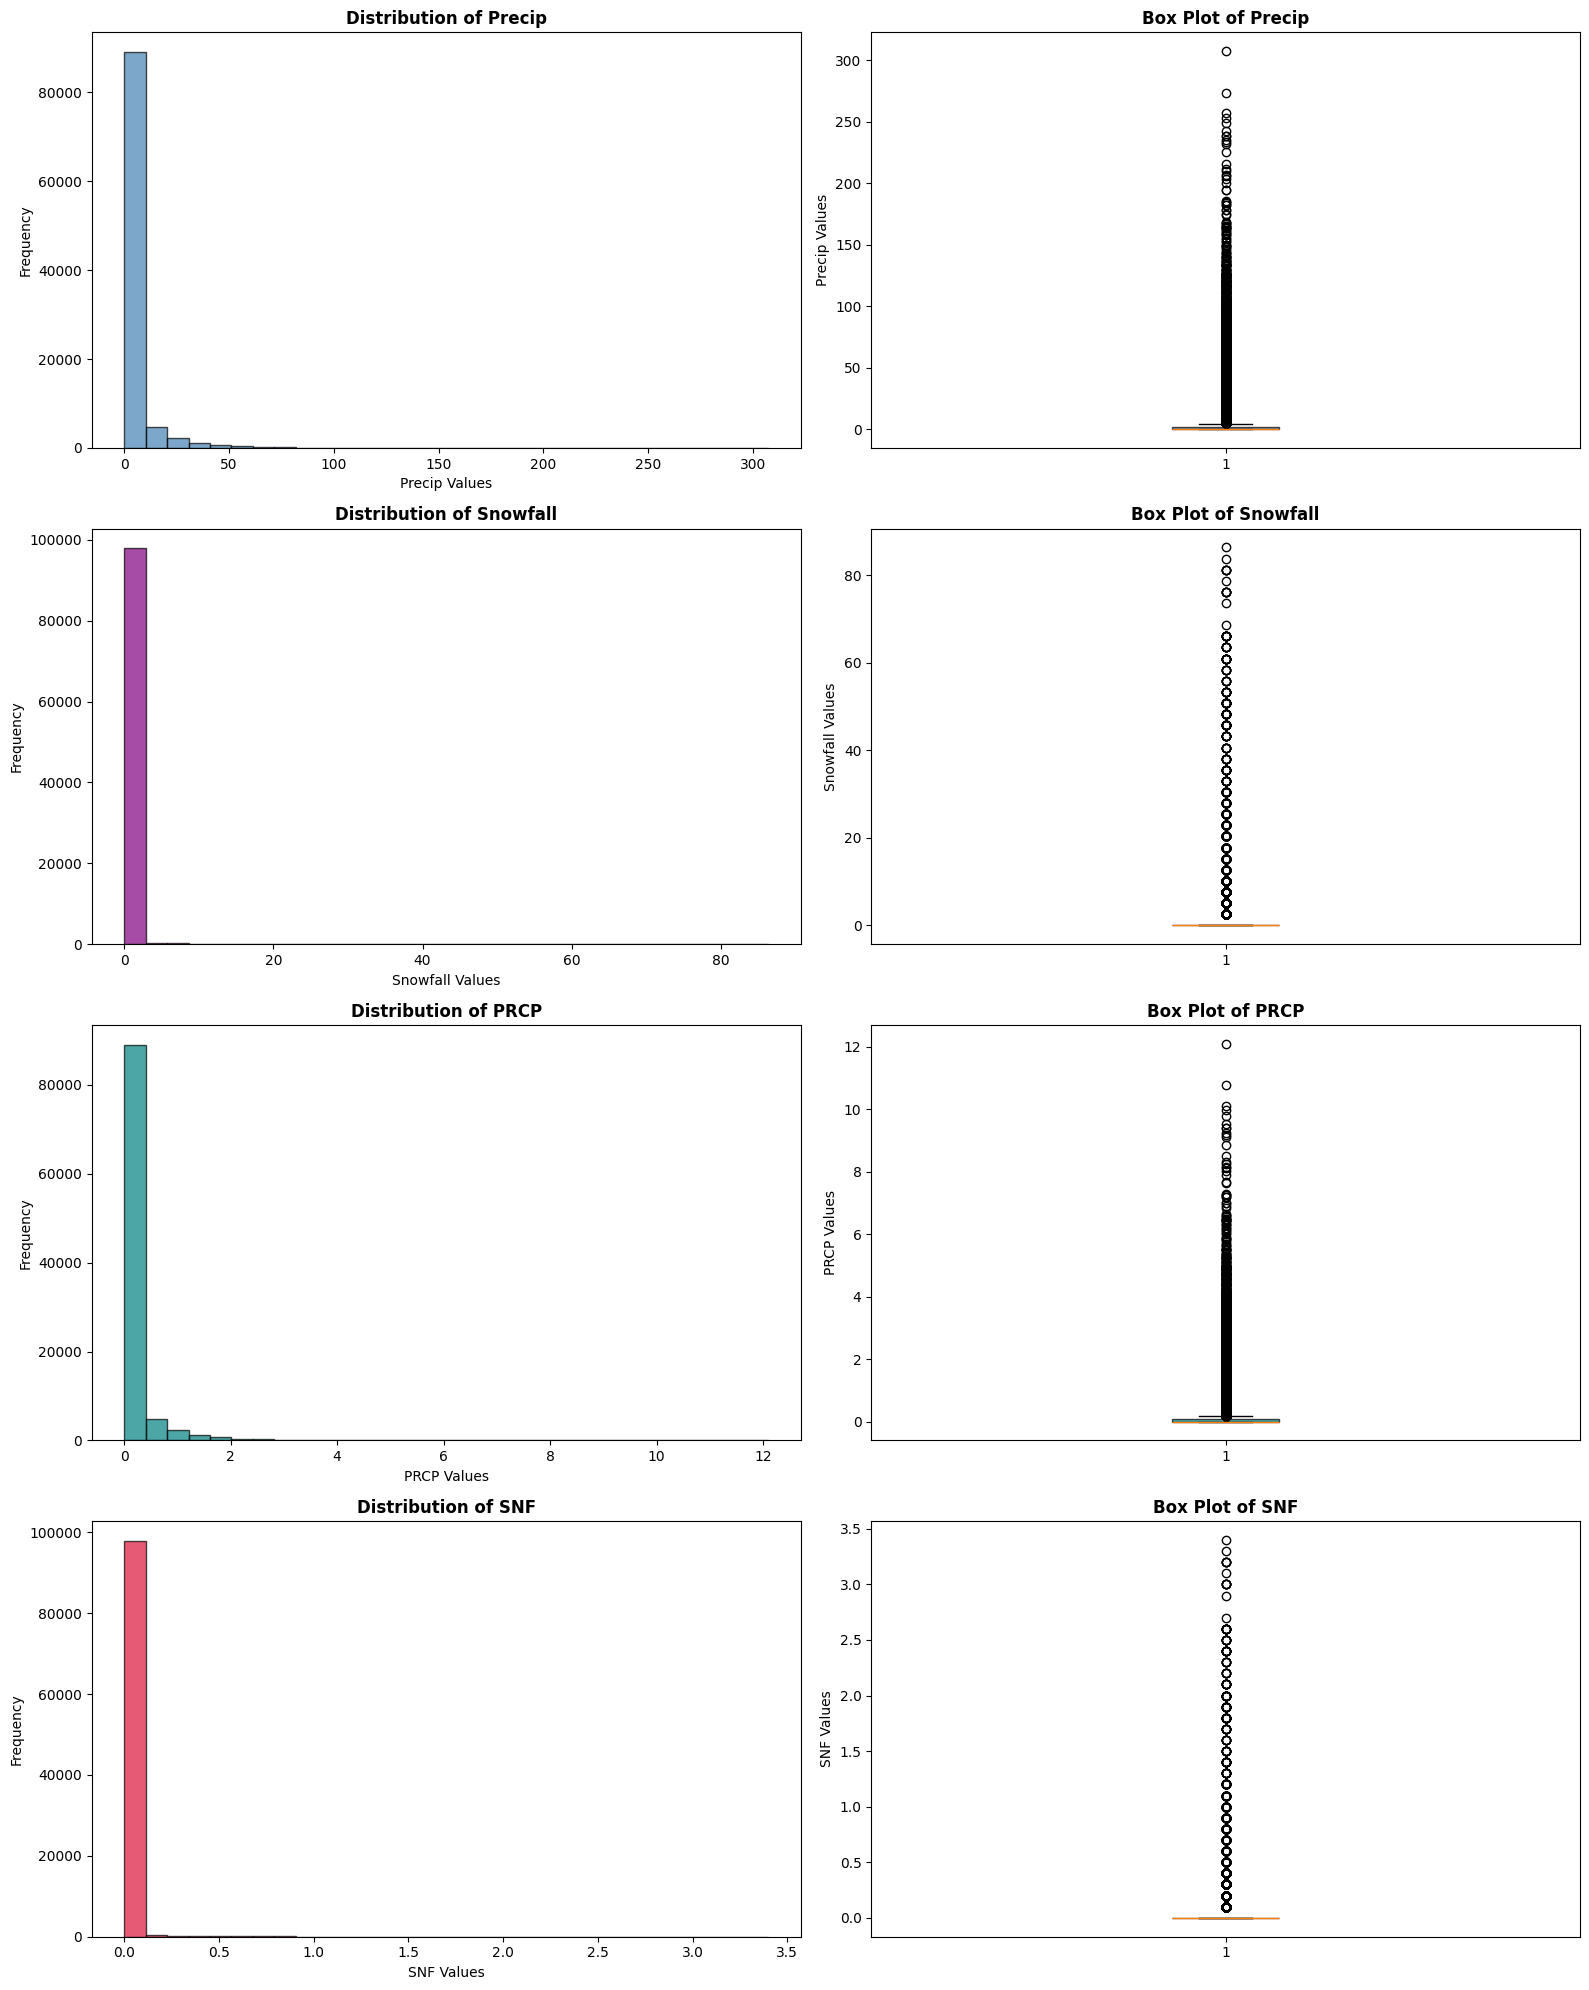

In [40]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
variables = ["Precip", "Snowfall", "PRCP", "SNF"]
colors = ["steelblue", "purple", "teal", "crimson"]

for i, (var, color) in enumerate(zip(variables, colors)):
    if var in df.columns:
        # Remove missing values for cleaner visualization
        data = df[var]

        # Histogram (left column)
        axes[i, 0].hist(data, bins=30, alpha=0.7, color=color, edgecolor="black")
        axes[i, 0].set_title(f"Distribution of {var}", fontsize=12, fontweight="bold")
        axes[i, 0].set_xlabel(f"{var} Values")
        axes[i, 0].set_ylabel("Frequency")

        # Boxplot (right column)
        box_plot = axes[i, 1].boxplot(data.dropna(), patch_artist=True)
        box_plot["boxes"][0].set_facecolor(color)
        box_plot["boxes"][0].set_alpha(0.7)
        axes[i, 1].set_title(f"Box Plot of {var}", fontsize=12, fontweight="bold")
        axes[i, 1].set_ylabel(f"{var} Values")

plt.tight_layout()
plt.show()

## 2. Clean the dataset and drop variables


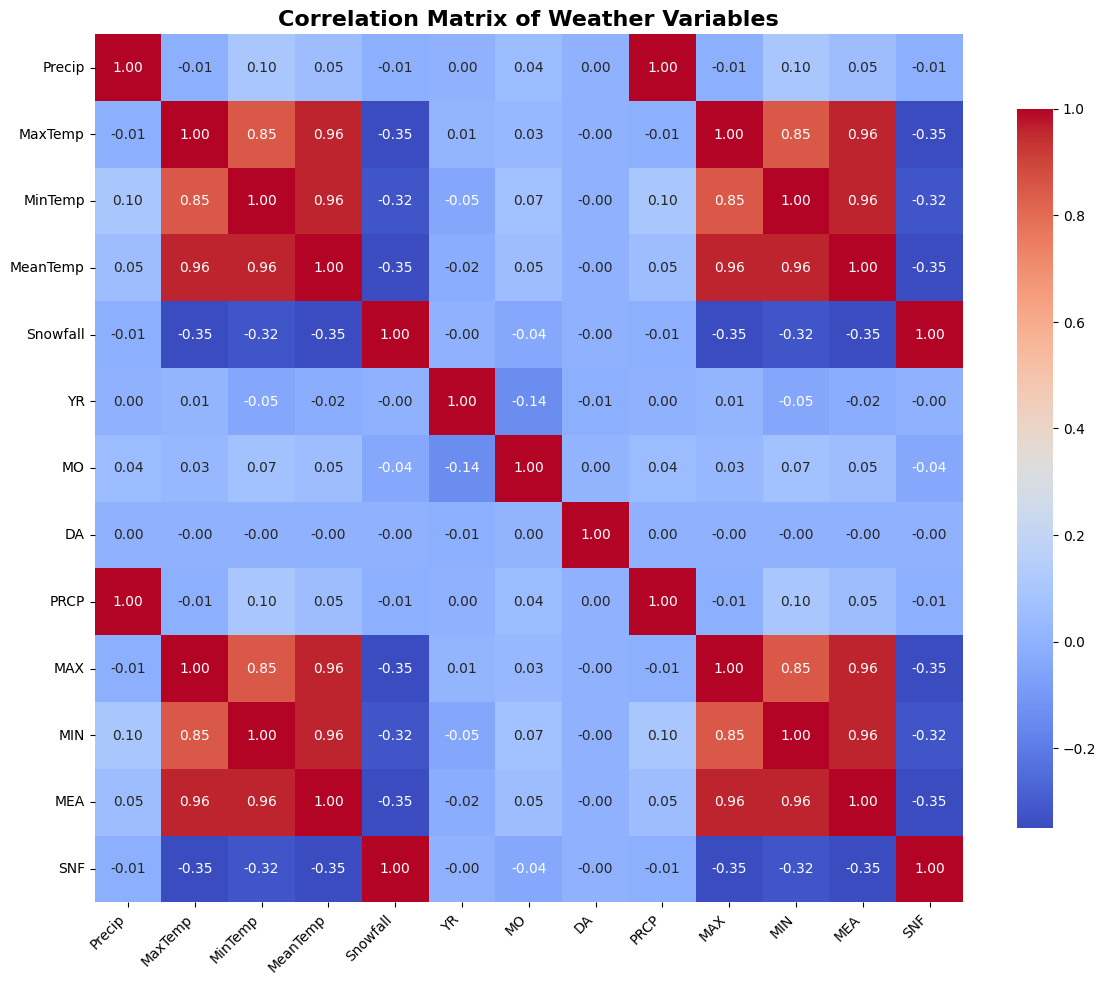

In [41]:
# Correlation analysis
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix of Weather Variables", fontsize=16, fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

- Precip and PRCP have a correlation of 1; therefore, one can be dropped.
- Snowfall and SNF have a correlation of 1; therefore, one can be dropped.
- MaxTemp, MinTemp, and MeanTemp have perfect correlation with MAX, MIN, and MEA respectively; therefore, MAX, MIN, and MEA can be dropped.
- Additionally, MaxTemp and MeanTemp show high positive correlation, it can lead to Multicollinearity, so I will drop MeanTemp.
- MaxTemp and MinTemp have high correlation, indicating that MaxTemp is an important variable for predicting MinTemp.


## 3. Select features for the model and explain the rationale


In [42]:
# Based on the high correlation values, we can drop some variables. The remaining features are:
feature = ["MaxTemp", "Precip", "YR", "MO", "DA", "Snowfall"]

In [44]:
X = df[feature]
y = df["MinTemp"]

# One-hot encoding for categorical variables
X = pd.get_dummies(X, columns=["YR", "MO", "DA"], drop_first=True)
X

,MaxTemp,Precip,Snowfall,YR_41,YR_42,YR_43,YR_44,YR_45,MO_2,MO_3,...,DA_22,DA_23,DA_24,DA_25,DA_26,DA_27,DA_28,DA_29,DA_30,DA_31
0,25.555556,1.016,0.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,28.888889,0.000,0.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,26.111111,2.540,0.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,26.666667,2.540,0.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,26.666667,0.000,0.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119035,28.333333,0.000,0.0,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
119036,29.444444,9.906,0.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
119037,28.333333,0.000,0.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
119038,28.333333,0.000,0.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


## 4. Split the dataset (80% for training, 20% for testing)


In [45]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 5. Choose the algorithm, train, and test the model


In [46]:
# Since the target variable is MinTemp (continuous variable), I choose Linear Regression for prediction.
from sklearn.linear_model import LinearRegression

# Instantiate the model
reg = LinearRegression()
# Fit the model on the training data
reg.fit(X_train, y_train)
# Predict on the test set
y_pred = reg.predict(X_test)

## 6. Evaluate and visualize model performance


R^2: 0.7525
RMSE: 3.8462


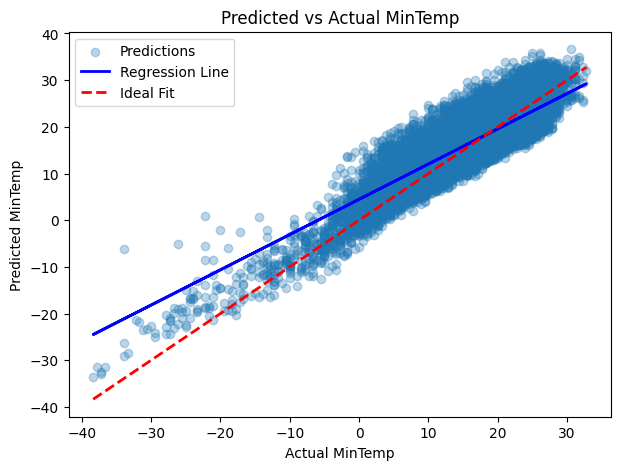

In [48]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R^2 and RMSE
r2 = r2_score(y_test, y_pred)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot predicted vs true values with regression line and ideal fit
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.3, label="Predictions")

# Fit a regression line to the predictions
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "b-", lw=2, label="Regression Line")

# Plot the ideal fit line (y = x)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    lw=2,
    label="Ideal Fit",
)
plt.xlabel("Actual MinTemp")
plt.ylabel("Predicted MinTemp")
plt.title("Predicted vs Actual MinTemp")
plt.legend()
plt.show()

## 7. What are the R² value and RMSE of the model? How do these values indicate model performance?


R² value: 0.7525

RMSE: 3.8462

The R² value of 0.7525 indicates that the independent variables — MaxTemp, Precip, YR, MO, DA, and Snowfall — explain approximately 75.25% of the variance in MinTemp.

The RMSE of 3.8462 suggests that, on average, the model’s predicted MinTemp deviates from the actual values by about 3.8°C.

## 8. Discuss the model performance based on the plot

The scatter plot of predicted vs. actual MinTemp shows that the model captures the overall trend well, with most predictions closely following the ideal fit line (red dashed). However, the regression line (blue) slightly deviates from the ideal, indicating a minor bias. While the predictions are generally accurate, there is increased spread at the extreme low end of the temperature range, suggesting the model struggles more with very cold conditions. Overall, the plot supports the earlier metrics—an R² of 0.7525 and RMSE of 3.85°C—indicating good but not perfect predictive performance.